<a href="https://colab.research.google.com/github/JohnnyNewman/MA/blob/main/Evaluation_Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
# check if already in right local directory
# otherwise clone the repo from github and change directory

cwd = os.getcwd()
print(os.path.split(cwd))

if not os.path.split(cwd)[1] == "MA":
    !git clone https://www.github.com/JohnnyNewman/MA.git
    os.chdir('MA')

('C:\\Users\\Nils\\Workspace\\MA_git', 'MA')


In [3]:
import pickle

In [4]:
import torch

In [5]:
from base import *

In [6]:
# load data

x_train = pickle.load(open("save/x_train.p", "rb"))
x_test = pickle.load(open("save/x_test.p", "rb"))
y_train = pickle.load(open("save/y_train.p", "rb"))
y_test = pickle.load(open("save/y_test.p", "rb"))
c_D_train = pickle.load(open("save/c_D_train.p", "rb"))
c_D_test = pickle.load(open("save/c_D_test.p", "rb"))

In [7]:
# load neural network models

In [8]:
net = torch.load("net6.pt", map_location=torch.device('cpu')).eval()

In [9]:
tm2 = torch.load("net6_tm2.pt", map_location=torch.device('cpu')).eval()

In [10]:
# display network architecture

net

TestModel(
  (encoder): Sequential(
    (0): Conv1d(2, 32, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): PReLU(num_parameters=1)
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(15,), stride=(1,), padding=(7,))
    (4): PReLU(num_parameters=1)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 32, kernel_size=(15,), stride=(1,), padding=(7,))
    (7): PReLU(num_parameters=1)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): Conv1d(32, 1, kernel_size=(1,), stride=(1,))
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ConvTranspose1d(1, 32, kernel_size=(7,), stride=(2,))
    (2): PReLU(num_parameters=1)
    (3): ConvTranspose1d(32, 64, kernel_size=(7,), stride=(2,))
    (4): PReLU(num_parameters=1)
    (5): ConvTranspose1d(64, 64, kernel_size=(7,), stride=(2,))
    (6): PReLU(num_parameter

In [11]:
# produce latent vectors from input

Z_train = net.encoder(x_train).detach().view(-1, 64)
Z_test = net.encoder(x_test).detach().view(-1, 64)

In [12]:
Z = np.vstack((Z_train, Z_test))

In [13]:
c_D = torch.cat((c_D_train, c_D_test))

In [14]:
c_D.shape, c_D_train.shape, c_D_test.shape

(torch.Size([924]), torch.Size([739]), torch.Size([185]))

In [15]:
from sklearn.manifold import TSNE

(924, 2)


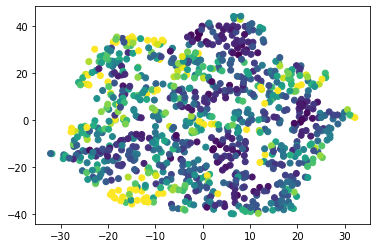

In [16]:
# create 2-dimensional representation of the latent vectors for vizualisation
# using t-distributed stochastic neighbor embedding (t-SNE)

tsne = TSNE(metric="cosine")
emb = tsne.fit_transform(Z)
print(emb.shape)

plt.scatter(emb[:,0], emb[:,1], c=np.clip(c_D, a_max=0.03, a_min=0))

In [17]:
# Try to fit a Gaussian Process Regressor to the latent vectors (input) and c_D values (output)

In [18]:
from sklearn.gaussian_process.kernels import PairwiseKernel, Product
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)


In [19]:
pk = PairwiseKernel(metric="cosine")
kernel = Product(pk, pk)
kernel = ConstantKernel()*pk*pk + WhiteKernel(noise_level=1e-05, noise_level_bounds=(1e-12, 1e-03))

In [20]:
gp = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.000001,n_restarts_optimizer=3).fit(Z_train, c_D_train)
print(gp.kernel_)
print(gp.score(Z_train, c_D_train))
print(gp.score(Z_test, c_D_test))
print(gp.log_marginal_likelihood())

0.584**2 * PairwiseKernel(gamma=1.0, metric=cosine) * PairwiseKernel(gamma=1.0, metric=cosine) + WhiteKernel(noise_level=4.79e-06)
0.8487006189482245
0.8159446495405189
3327.338373542557


In [21]:
Z_train.shape, y_train.shape

(torch.Size([739, 64]), torch.Size([739, 4, 192]))

In [22]:
c_D_train_predicted = gp.predict(Z_train)
c_D_test_predicted = gp.predict(Z_test)

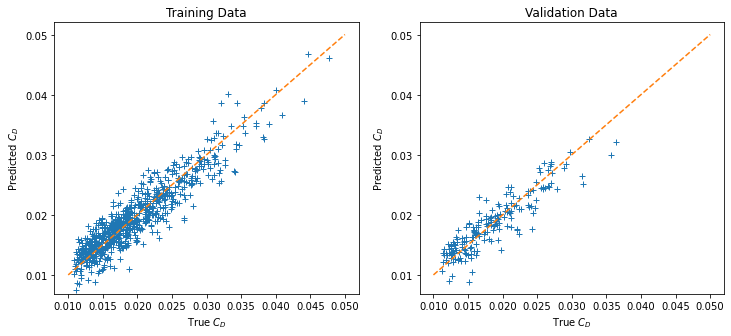

In [23]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)

#plt.plot(y_pred)
plt.plot(c_D_train, c_D_train_predicted, '+')
plt.plot([0.01, 0.05], [0.01, 0.05], "--")

#plt.gca().set_xlim([0.008, 0.042])
#plt.gca().set_ylim([0.008, 0.042])
ax1 = plt.gca()
ax1.set_ylabel("Predicted $C_D$")
ax1.set_xlabel("True $C_D$")
ax1.set_title("Training Data")

plt.subplot(1, 2, 2)

#plt.plot(y_pred)
plt.plot(c_D_test, c_D_test_predicted, '+', label="asd")
plt.plot([0.01, 0.05], [0.01, 0.05], "--")
#plt.plot(y_pred, 'o', c="r")
ax1.set_xlim(plt.gca().get_xlim())
ax1.set_ylim(plt.gca().get_ylim())
ax2 = plt.gca()
ax2.set_ylabel("Predicted $C_D$")
ax2.set_xlabel("True $C_D$")
ax2.set_title("Validation Data")
pass

In [24]:
c_D_train_predicted2 = tm2(Z_train).detach()
c_D_test_predicted2 = tm2(Z_test).detach()

Text(0.5, 1.0, 'Validation Data')

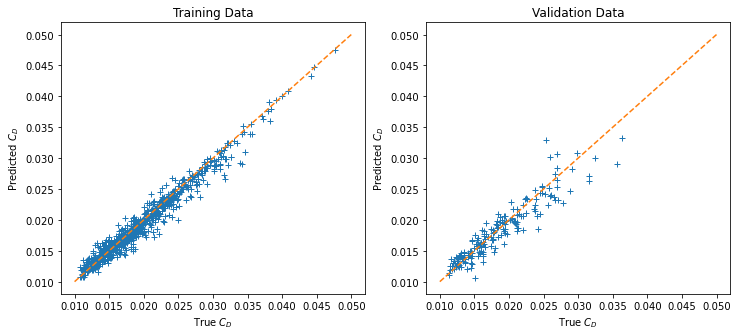

In [25]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)

#plt.plot(y_pred)
plt.plot(c_D_train, c_D_train_predicted2, '+')
plt.plot([0.01, 0.05], [0.01, 0.05], "--")

#plt.gca().set_xlim([0.008, 0.042])
#plt.gca().set_ylim([0.008, 0.042])
ax1 = plt.gca()
ax1.set_ylabel("Predicted $C_D$")
ax1.set_xlabel("True $C_D$")
ax1.set_title("Training Data")

plt.subplot(1, 2, 2)

#plt.plot(y_pred)
plt.plot(c_D_test, c_D_test_predicted2, '+', label="asd")
plt.plot([0.01, 0.05], [0.01, 0.05], "--")
#plt.plot(y_pred, 'o', c="r")
ax1.set_xlim(plt.gca().get_xlim())
ax1.set_ylim(plt.gca().get_ylim())
ax2 = plt.gca()
ax2.set_ylabel("Predicted $C_D$")
ax2.set_xlabel("True $C_D$")
ax2.set_title("Validation Data")

In [26]:
# do a PCA decompositon of the latent vectors and fit GPR to this representation

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=10, svd_solver="full")
pca.fit(Z_train)

PCA(n_components=10, svd_solver='full')

In [29]:
pca.explained_variance_

array([3.91006600e+02, 1.94140843e+02, 1.87257250e+02, 5.72166326e+01,
       2.92216101e+01, 1.23870807e+01, 4.55161368e+00, 1.57648269e+00,
       3.93548679e-01, 1.32676105e-01])

In [30]:
pca.explained_variance_ratio_.cumsum()

array([0.4453244 , 0.66643487, 0.87970549, 0.94487054, 0.97815155,
       0.99225942, 0.99744333, 0.99923882, 0.99968704, 0.99983814])

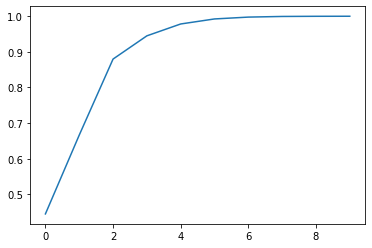

In [31]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [32]:
ls = 1 / pca.singular_values_ ** 2

In [33]:
ls

array([3.46544931e-06, 6.97953883e-06, 7.23610730e-06, 2.36821618e-05,
       4.63702564e-05, 1.09389257e-04, 2.97699595e-04, 8.59516925e-04,
       3.44306467e-03, 1.02129434e-02])

In [34]:
kernel = 1.0 * RBF(length_scale=ls, length_scale_bounds=(1e-7, 10.0)) #+ WhiteKernel(noise_level=1e-05, noise_level_bounds=(1e-09, 1e-04))# + ConstantKernel()

In [35]:
gp = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.000001,n_restarts_optimizer=1).fit(pca.transform(Z_train), c_D_train)
print(gp.kernel_)
print(gp.score(pca.transform(Z_train), c_D_train))
print(gp.score(pca.transform(Z_test), c_D_test))
print(gp.log_marginal_likelihood())

0.0206**2 * RBF(length_scale=[0.0527, 0.00664, 0.00229, 0.000245, 0.0147, 0.000317, 1.36, 5.12, 0.000117, 0.216])
0.9999415182100025
-12.60909096169599
1821.099928308813


In [36]:
# alternatively to the TSNE embedding, I tried umap embedding
# https://umap-learn.readthedocs.io/

In [37]:
#!pip install umap-learn

In [38]:
#import umap

In [39]:
#reducer = umap.UMAP()

In [40]:
#embedding_umap = reducer.fit_transform(Z)

In [41]:
#plt.scatter(embedding_umap[:,0], embedding_umap[:,1], c=np.clip(c_D, a_max=0.0275, a_min=0))

In [42]:
# you will need the library 'bokeh' to display the plots
# it will be automatically installed by the following command

!pip install bokeh

In [43]:
import bokeh

In [44]:

from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.tools import TapTool, LassoSelectTool, HoverTool
from bokeh.themes import Theme
import yaml

In [45]:
# this will create an interactive vizualisation of the airfoils and their embedded latent vectors 
# unfortunately google colab does not allow this
# but should work locally

output_notebook()

def bkapp(doc):
    
    data = ColumnDataSource({
    "x": emb[:,0],
    "y": emb[:,1],
    "c": c_D_train.numpy(),
    "is_train": [1]*x_train.shape[0] + [0] * x_test.shape[0],
    })
    
    s1 = figure(width=50, plot_height=200, title=None, name="asd")
    s1.scatter("x", "y", source=data, size=10, fill_color=bokeh.transform.linear_cmap("c", bokeh.palettes.Plasma256, 0.0, 0.03))
    
    i = 0
    airfoil_data = ColumnDataSource({
    "x": x_train[i, 0, :].numpy(),
    "y": 10*x_train[i, 1, :].numpy(),
    "cp": y_train[i, 0, :].numpy(),    
    "cd": np.ones(192)*c_D_train[i].numpy(),
    })
    
    s2 = figure(width=50, plot_height=100)    
    #s2.circle(, x_train[i, 1, :].numpy())
    s2.scatter("x", "y", source=airfoil_data, fill_color=bokeh.transform.linear_cmap("cd", "Plasma256", 0.0, 0.05))
    
    #s3 = figure(width=50, plot_height=100)    
    s2.square("x", "cp", source=airfoil_data, fill_color=bokeh.transform.linear_cmap("cd", "Plasma256", 0.0, 0.05))
    
    hover = HoverTool(tooltips=[("c_D", "@c")])
    s1.add_tools(TapTool(), LassoSelectTool(), hover)

    p = gridplot([[s1],[s2]])

    def selection_change(attrname, old, new):
        print(attrname, old, new)
        if len(new) >= 1:
            airfoil_data.data = {k: [] for k in airfoil_data.data}
            #i = new[0]
            for i in new:
                airfoil_data.data["x"] = np.hstack((airfoil_data.data["x"], x_train[i, 0, :].numpy()))
                airfoil_data.data["y"] = np.hstack((airfoil_data.data["y"], 10*x_train[i, 1, :].numpy()))
                airfoil_data.data["cp"] = np.hstack((airfoil_data.data["cp"], y_train[i, 0, :].numpy()))
                airfoil_data.data["cd"] = np.hstack((airfoil_data.data["cd"], np.ones(192)*c_D_train[i].numpy()))
            #airfoil_data.data = {"x": x_train[i, 0, :].numpy(), "y": 10*x_train[i, 1, :].numpy(), "cp": y_train[i, 0, :].numpy() for i in new}
            #s2.circle(x_train[i, 0, :].numpy(), x_train[i, 1, :].numpy())
        pass

    data.selected.on_change('indices', selection_change)
    #hover.on_change("data", selection_change)
    
    doc.add_root(p)
    doc.theme = Theme(json=yaml.load("""
        attrs:
            Figure:
                toolbar_location: above
                height: 500
                width: 800
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

Loading BokehJS ...

indices [] [418, 671]


indices [418, 671] []
indices [] [480]


indices [480] [123, 229]


indices [123, 229] [108, 495]


indices [108, 495] [291, 458]


indices [291, 458] [225]
